In [ ]:
import numpy
import collections
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import numpy
import numpy as np
import scanpy as sc

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80,facecolor='white')

from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding

In [2]:
adata = sc.read("PBMC.h5ad")

# Process Data

In [ ]:
dataset = GeneVectorDataset(adata)

# Setup Model

In [ ]:
cmps = GeneVector(dataset,
                  output_file="pbmc.vec",
                  initial_lr=0.15,
                  emb_dimension=100)

# Train Network

In [ ]:
for _ in range(25):
    cmps.train(20)
    embed = GeneEmbedding("pbmc.vec", dataset, vector="average")
    print("Similarity to CD8A:")
    print(embed.compute_similarities("CD8A")[:10])

# Get Cell Embedding

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14039/14039 [00:11<00:00, 1175.75it/s]


computing neighbors


OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


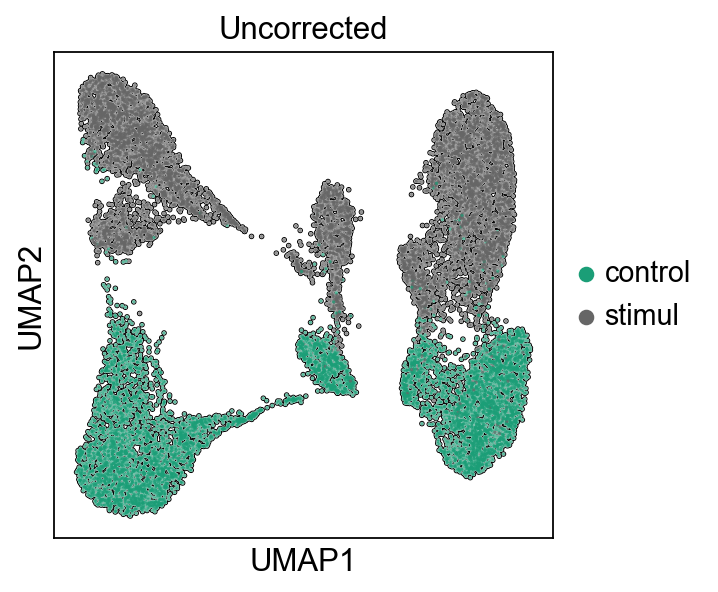

In [6]:
cembed = CellEmbedding(dataset, embed)
adata = cembed.get_adata()
sc.pl.umap(adata,palette="Dark2",color=["sample"], title=["Uncorrected"],add_outline=True)

# Batch Correction

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14039/14039 [00:10<00:00, 1278.67it/s]


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


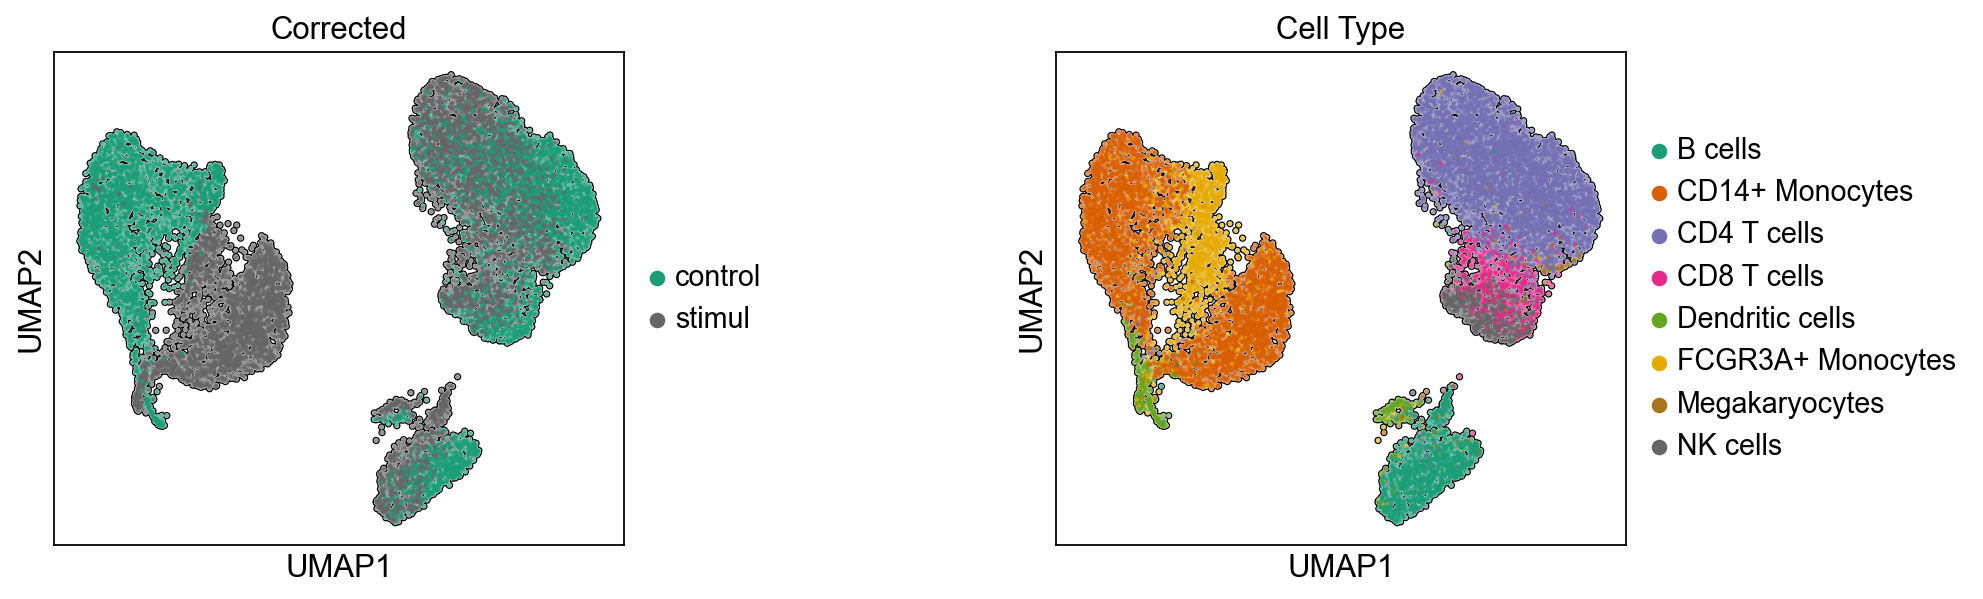

In [7]:
cembed = CellEmbedding(dataset, embed)
cembed.batch_correct(column="sample")
adata = cembed.get_adata()
sc.pl.umap(adata,palette="Dark2",color=["sample","celltype"], wspace=0.6,
                                 title=["Corrected","Cell Type"],add_outline=True,size=15)

# Plot Gene Similarity

<AxesSubplot:xlabel='Similarity', ylabel='Gene'>

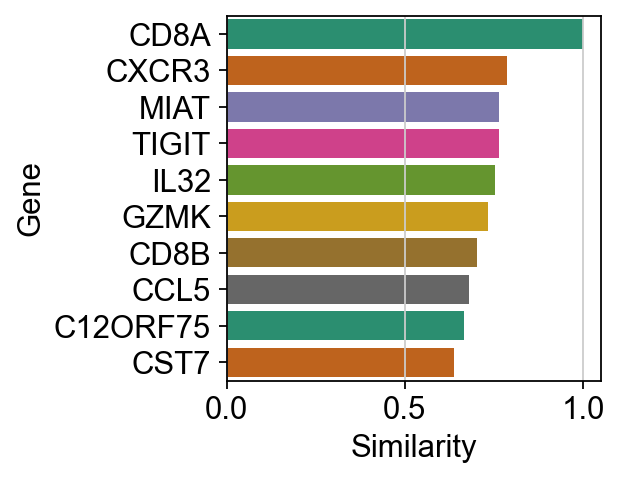

In [9]:
df = embed.compute_similarities("CD8A").head(10)
fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.barplot(data=df,y="Gene",x="Similarity",palette="Dark2",ax=ax)

# Get Gene Embedding

In [10]:
gdata = embed.get_adata()
metagenes = embed.get_metagenes(gdata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 178 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
embed.score_metagenes(adata, metagenes)

# Find CD8 Metagene

17 ['C12ORF75', 'CD8A', 'CD8B', 'CXCR3', 'DUSP2', 'GZMK', 'LAG3', 'MIAT', 'TIGIT', 'TPRG1']


/Users/nceglia/Codebase/genevector/gvenv/lib/python3.8/site-packages/anndata-0.8.0-py3.8.egg/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


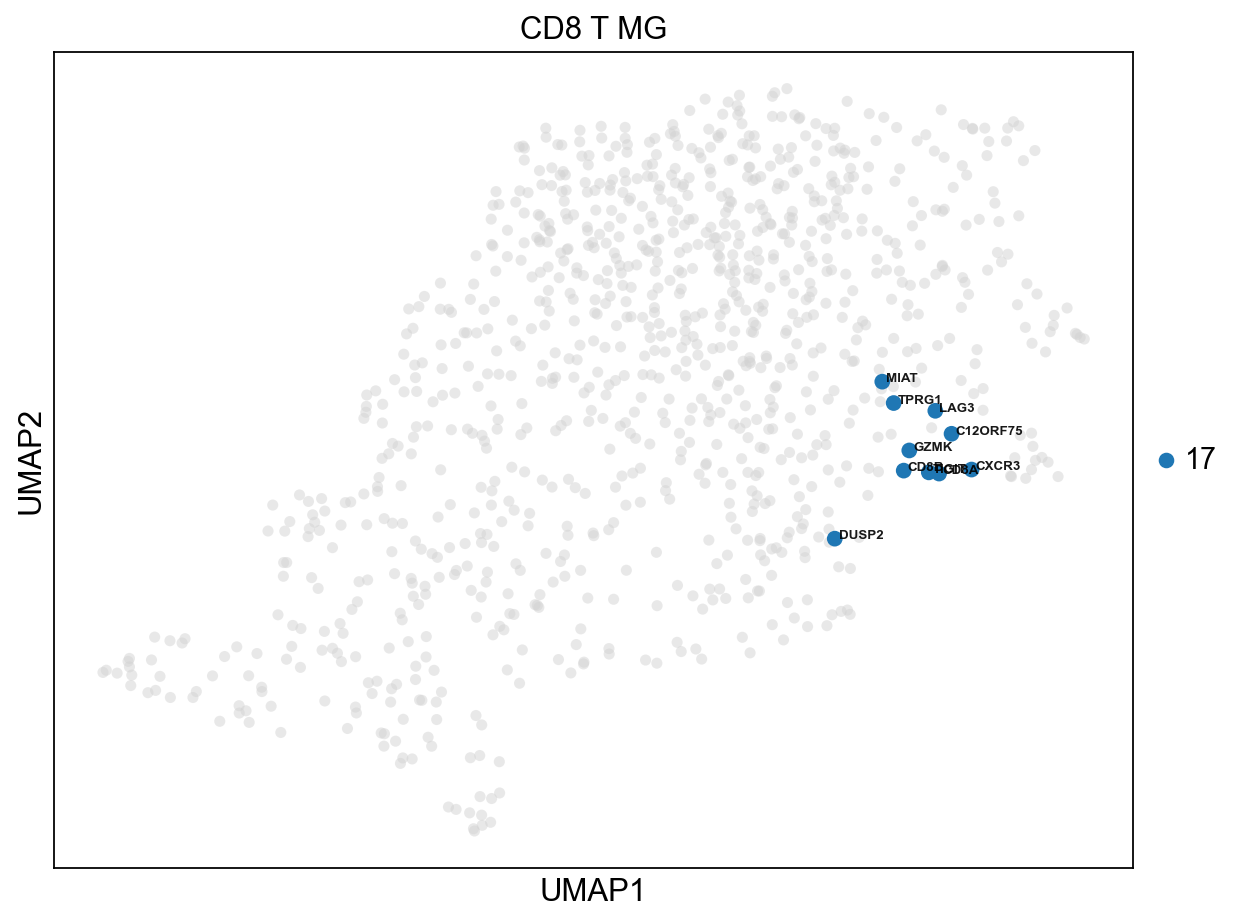

In [13]:
for clust, genes in metagenes.items():
    if "CD8A" in genes:
        print(clust,genes)
        embed.plot_metagene(gdata, mg=clust, title="CD8 T MG")

# Find Interferon Stimulated Metagene

14 ['GBP1', 'IFIT1', 'IFIT2', 'IFIT3', 'IRF7', 'LAP3', 'LY6E', 'MT2A', 'MX1', 'OAS1', 'SAMD9L']


/Users/nceglia/Codebase/genevector/gvenv/lib/python3.8/site-packages/anndata-0.8.0-py3.8.egg/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


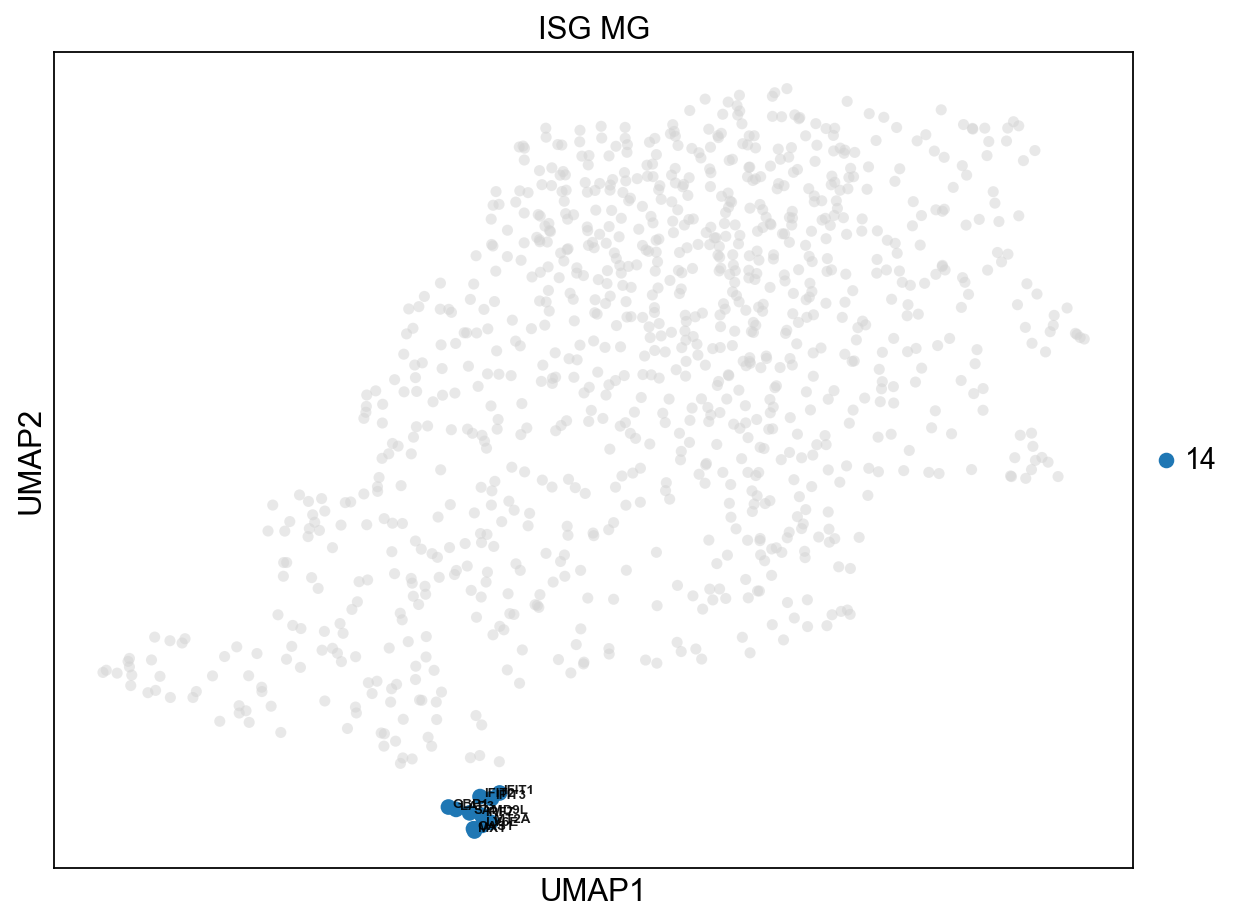

In [15]:
isg_sig = None
for clust, genes in metagenes.items():
    if "IFIT1" in genes:
        isg_sig = clust
        print(clust,genes)
        embed.plot_metagene(gdata, mg=clust, title="ISG MG")

# Find Markers of Cell Type and Batch

In [16]:
markers = cembed.get_predictive_genes(adata,"detailed_celltype")
pandas.DataFrame.from_dict(markers).T

0         1         2      3         4  \
control_CD14+ Monocytes     FCN1      MAFB  C15ORF48  PLAUR      CST3   
control_Dendritic cells     CST3  C15ORF48       LYZ   KYNU       CFP   
control_CD4 T cells         PASK     TRAT1       LTB  ITM2A      IL32   
control_CD8 T cells        KLRD1      PRF1      GZMA   GZMK      CTSW   
control_B cells            MS4A1     CD79A     BANK1   CD70       LY9   
control_FCGR3A+ Monocytes  IGSF6     MS4A7      CST3    CFD     C3AR1   
control_Megakaryocytes     SPARC      PPBP    TREML1  ACRBP      SDPR   
control_NK cells           KLRD1      GZMA      PRF1  CLIC3      GZMB   
stimul_CD14+ Monocytes      FCN1     IGSF6      MAFB   CST3  C15ORF48   
stimul_Dendritic cells      CST3       CFP  C15ORF48    LYZ   SLC7A11   
stimul_CD4 T cells         TRAT1       LTB      PASK   CCR7      IL32   
stimul_B cells             MS4A1     CD79A     BANK1   IRF8  ARHGAP24   
stimul_FCGR3A+ Monocytes   IGSF6      CST3      MAFB  MS4A7      FCN1   
stimul_CD8 T cells         KLRD1      GZMK     TIGIT   PRF1      GZMA   
stimul_NK cells            KLRD1      GZMA     CLIC3   PRF1      GNLY   
stimul_Megakaryocytes      SPARC    TREML1     ACRBP   PPBP      SDPR   

                                 5          6         7           8         9  
control_CD14+ Monocytes     FCER1G       CTSB      KYNU       IGSF6    PLA2G7  
control_Dendritic cells      IL4I1      IGSF6      CPVL        PLEK    LILRB4  
control_CD4 T cells           CCR7      SNHG8     S1PR1      GPR171      AQP3  
control_CD8 T cells          TIGIT      CXCR3      GZMH        CD8A     CLIC3  
control_B cells            POU2AF1  TNFRSF13B     TCL1A  AC006129.4      NME1  
control_FCGR3A+ Monocytes     FCN1       KYNU      MAFB      FCER1G  SERPINA1  
control_Megakaryocytes        MYL9      CMTM5       PF4       TUBB1      NRGN  
control_NK cells              GNLY       CTSW      GZMH      FGFBP2     SPON2  
stimul_CD14+ Monocytes      PLA2G7       CTSB      KYNU      FCER1G       CFP  
stimul_Dendritic cells         IL8       KYNU      CPVL       PLAUR    PLA2G7  
stimul_CD4 T cells          GPR171      SNHG8     ADTRP       ITM2A      ICOS  
stimul_B cells                CD70        LY9   POU2AF1         ID3    SYNGR2  
stimul_FCGR3A+ Monocytes      KYNU     FCER1G  C15ORF48         CFD     PLAUR  
stimul_CD8 T cells            CD8A       CTSW     CXCR3        GZMH      NKG7  
stimul_NK cells               GZMB       NKG7      CTSW        GZMH    FGFBP2  
stimul_Megakaryocytes         MYL9      TUBB1      NRGN         PF4     CMTM5

# Annotate Cell Types with Pseudo-probabilities

In [17]:
annotated_adata = cembed.phenotype_probability(adata,markers)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14039/14039 [00:00<00:00, 42952.03it/s]
/Users/nceglia/Codebase/genevector/gvenv/lib/python3.8/site-packages/genevector-0.0.1-py3.8.egg/genevector/embedding.py:587: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[target_col] = ct


control_CD14+ Monocytes
control_Dendritic cells
control_CD4 T cells
control_CD8 T cells
control_B cells
control_FCGR3A+ Monocytes
control_Megakaryocytes
control_NK cells
stimul_CD14+ Monocytes
stimul_Dendritic cells
stimul_CD4 T cells
stimul_B cells
stimul_FCGR3A+ Monocytes
stimul_CD8 T cells
stimul_NK cells
stimul_Megakaryocytes


# Plot Pseudo-probabilities

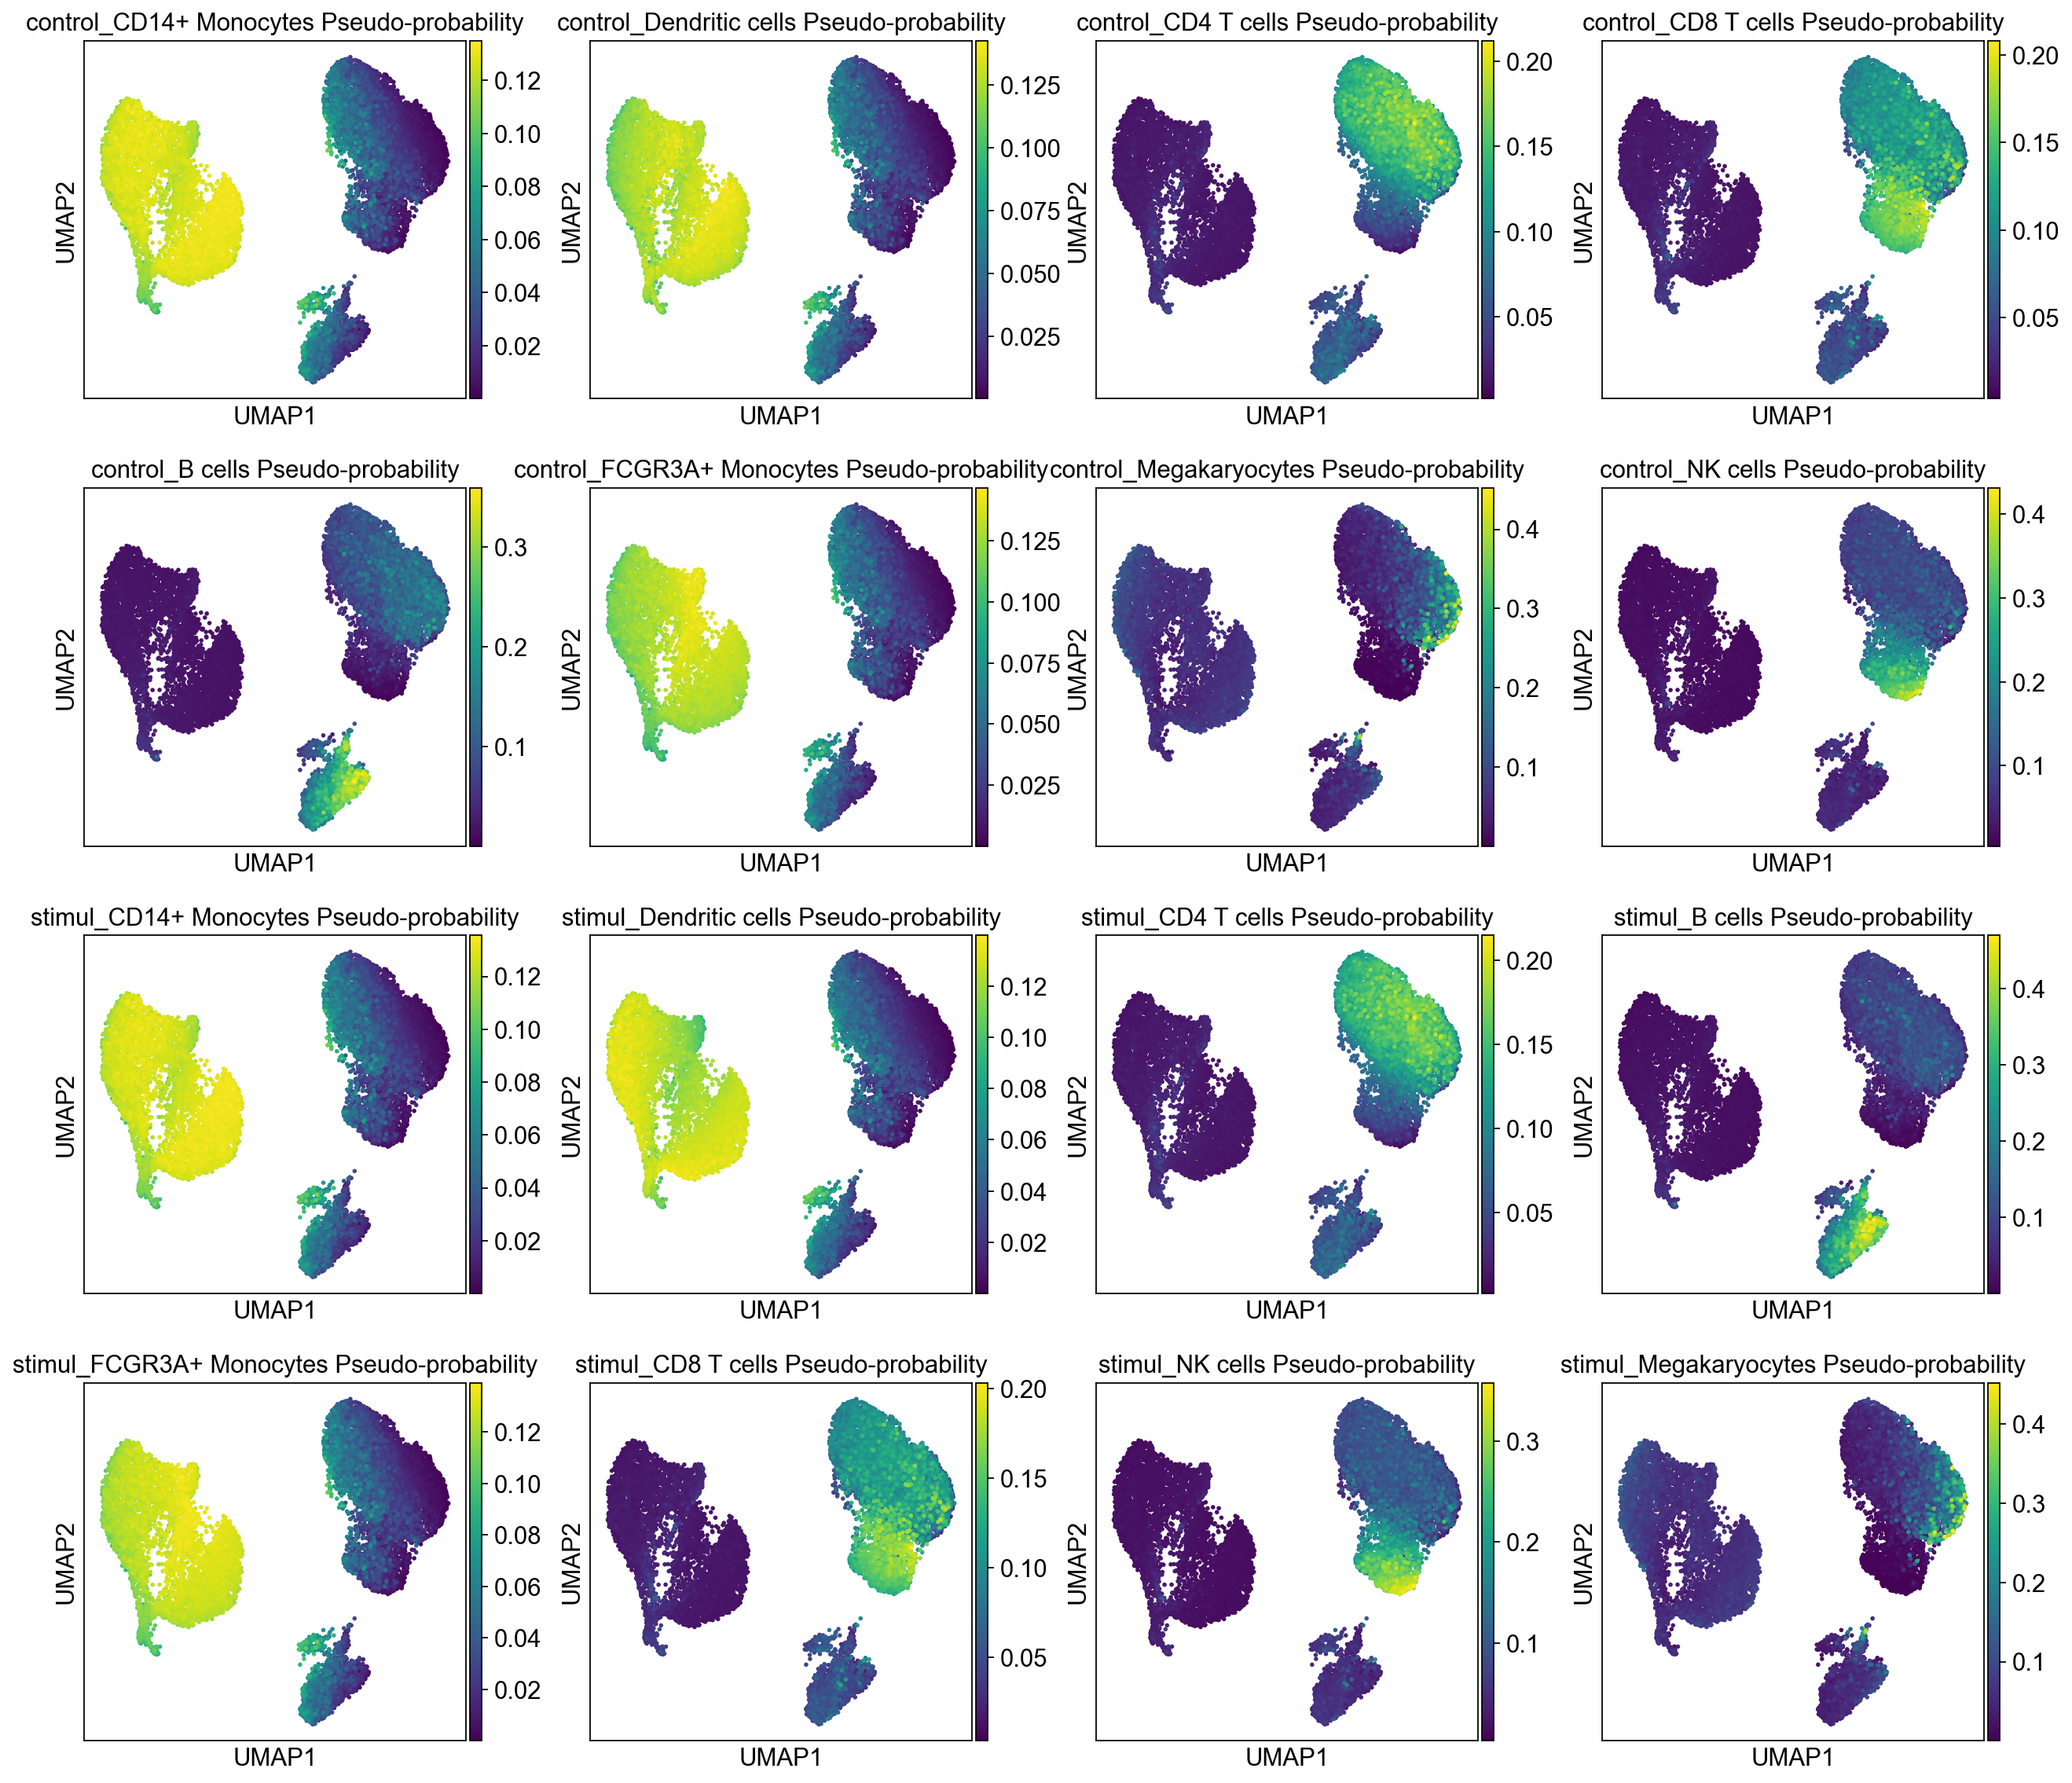

In [19]:
prob_cols = [x for x in annotated_adata.obs.columns.tolist() if "Pseudo-probability" in x]
sc.pl.umap(annotated_adata,color=prob_cols,size=25)

# Plot Cell Type Assignment

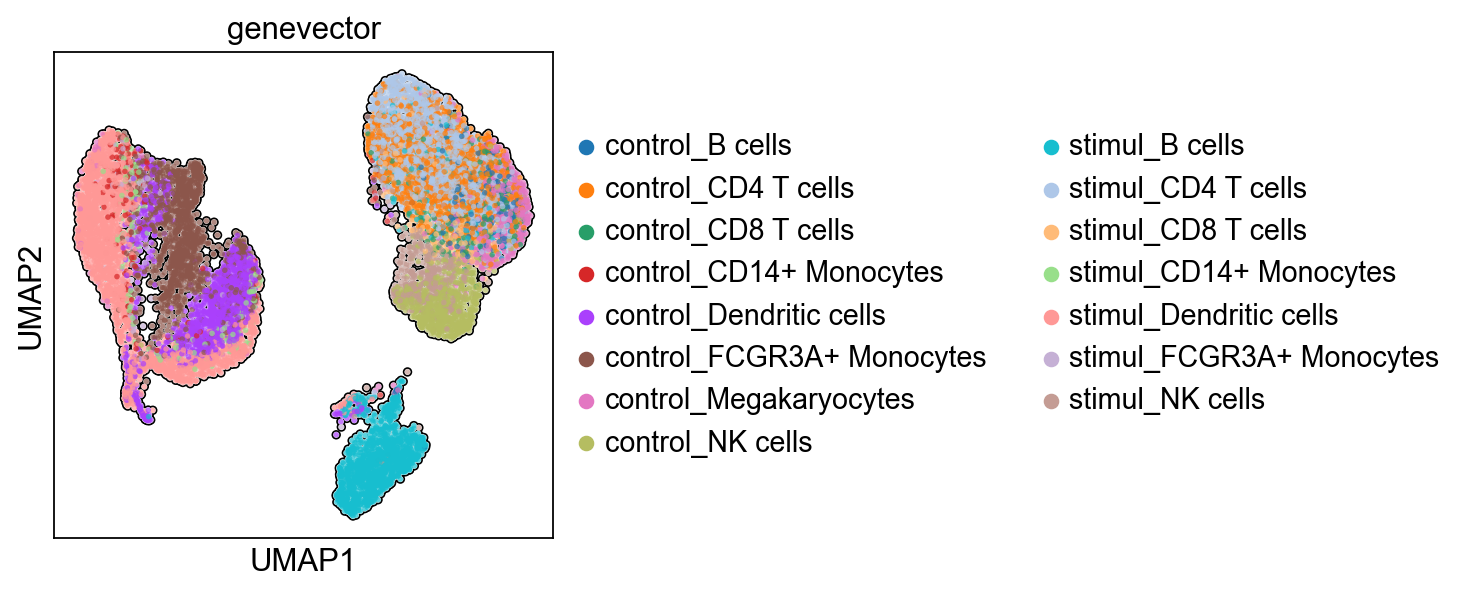

In [20]:
sc.pl.umap(annotated_adata,color="genevector",size=25,add_outline=True)

# Plot All Metagenes

<Figure size 400x1040 with 0 Axes>

<Figure size 320x320 with 0 Axes>

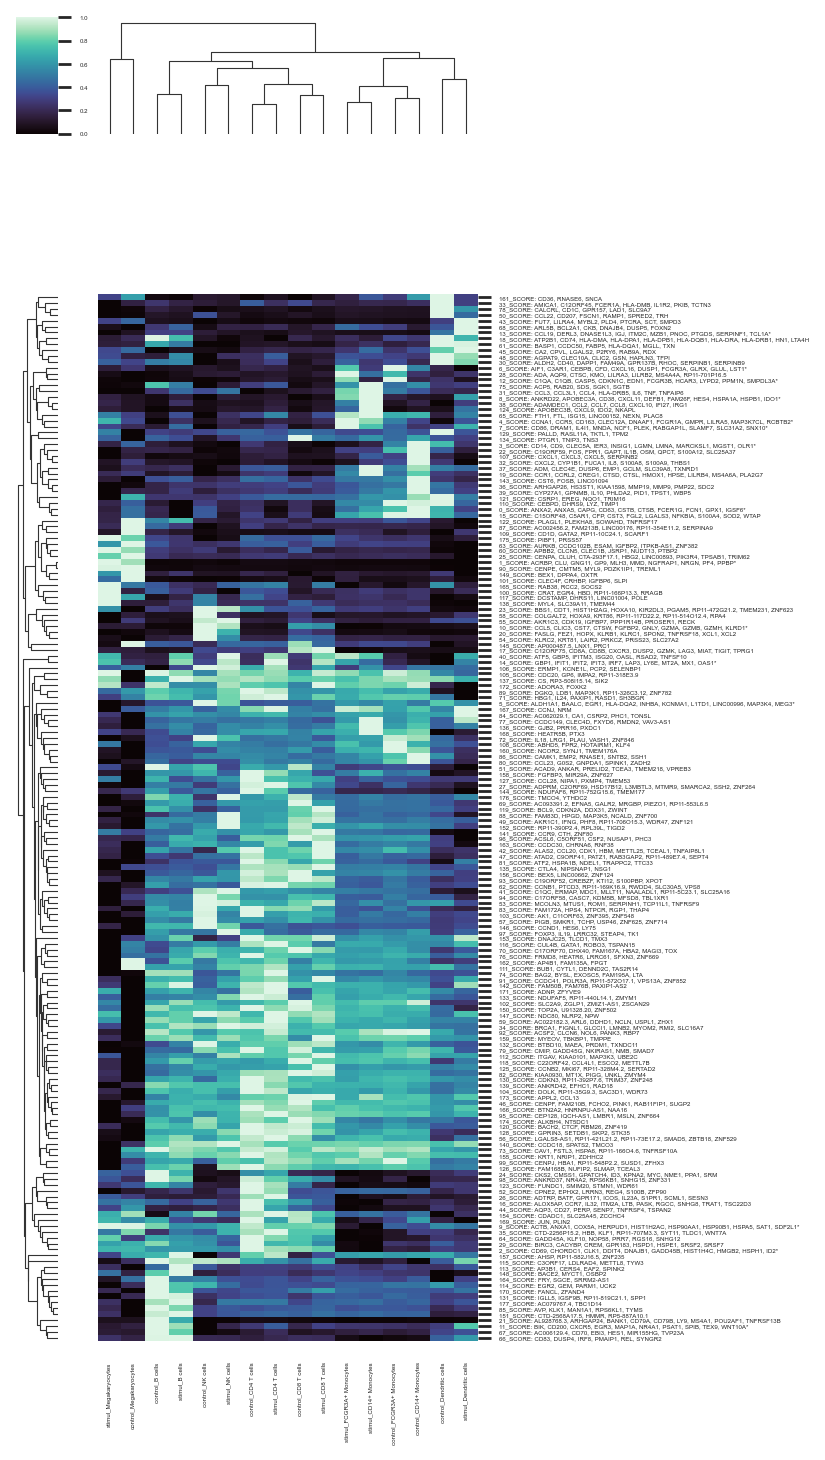

In [22]:
sns.set(font_scale=0.25)
embed.plot_metagenes_scores(adata,metagenes,"detailed_celltype")